In [33]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nilearn.image import load_img
sys.path.append('..')
from utils.data import Subject, load_participant_list
from utils.analysis import compute_parametric_modulator

In [34]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

all_sub_ids = load_participant_list(base_dir)

sub_ids = all_sub_ids

In [35]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]

/home/ubuntu/repos/learning-habits-analysis/notebooks/../utils/data.py:165: UserWarning: Last 1 trial(s) of block had no response, filling with 0
  warnings.warn(f"Last {n_missing} trial(s) of block had no response, filling with 0")


In [36]:
exclude_stimuli = False
hrf_model = 'spm'
modulator_normalization = 'zscore'
tr = 2.33384

In [37]:
columns_event = {'first_stim_value_rl':'first_stim_presentation',
                'first_stim_value_ck':'first_stim_presentation',
                'first_stim':'first_stim_presentation'}

In [38]:
img_path = subjects[0].img.get('learning1')
fmri_img = load_img(img_path)

n_learning = fmri_img.shape[-1]

img_path = subjects[0].img.get('test')
fmri_img = load_img(img_path)

n_test = fmri_img.shape[-1]

frametimes_learning = np.linspace(tr / 2., (n_learning - .5) * tr, n_learning)
frametimes_test = np.linspace(tr / 2., (n_test - .5) * tr, n_test)

In [39]:
events = []
modulators = []
for sub in subjects:
    for run in sub.runs:
        ev = getattr(sub, run).extend_events_df(columns_event)
        if exclude_stimuli:
            ev['trial_type'] = ev.apply(
                                        lambda row: f"{row['trial_type']}_{'exclude' if int(row['first_stim']) in (1, 8) else 'include'}"
                                        if row['trial_type'] == 'first_stim_presentation' else row['trial_type'],
                                        axis=1
                                        )
        events.append(ev)

        frametimes = frametimes_learning if 'learning' in run else frametimes_test
        # RL
        parametric_modulator_column = 'first_stim_value_rl'
        condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
        rl_modulation = compute_parametric_modulator(ev, condition, parametric_modulator_column,
                                                    frametimes, hrf_model, normalize=modulator_normalization)
        
        # CK
        parametric_modulator_column = 'first_stim_value_ck'
        ck_modulation = compute_parametric_modulator(ev, condition, parametric_modulator_column,
                                                    frametimes, hrf_model, normalize=modulator_normalization)
        
        modulators.append((rl_modulation, ck_modulation))


In [40]:
corr = []
for i, (rl_mod, ck_mod) in enumerate(modulators):
    corr.append(np.corrcoef(rl_mod.T, ck_mod.T)[0, 1])

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


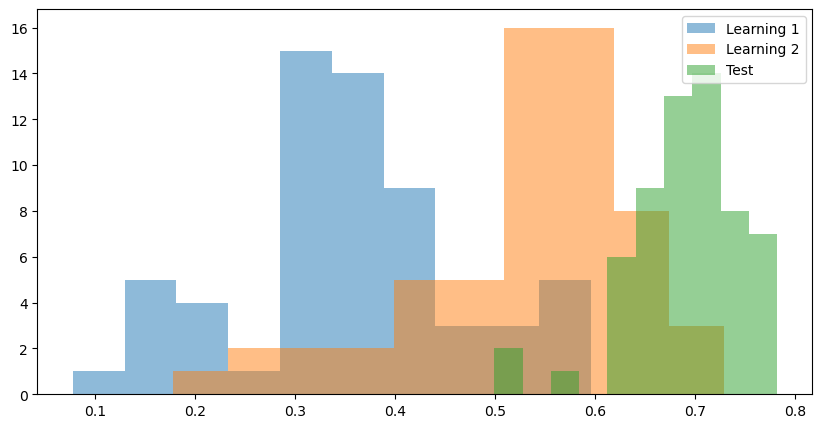

In [41]:
corr_run1 = corr[0::3]
corr_run2 = corr[1::3]
corr_run3 = corr[2::3]

plt.figure(figsize=(10, 5))
plt.hist(corr_run1, alpha=0.5, label='Learning 1')
plt.hist(corr_run2, alpha=0.5, label='Learning 2')
plt.hist(corr_run3, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.show()

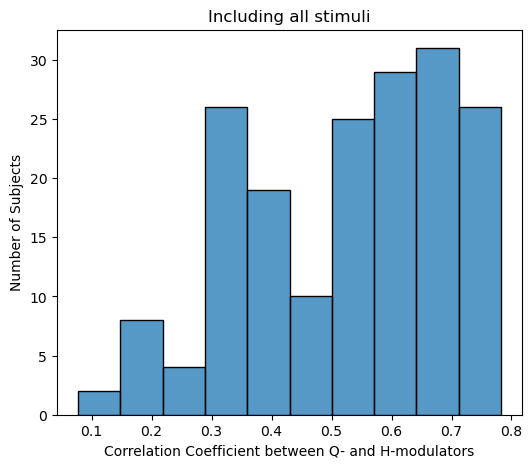

In [42]:
import seaborn as sns

# Create a histogram plot of corr
plt.figure(figsize=(6, 5))
sns.histplot(corr, kde=False, bins=10)
plt.title('Including all stimuli')
plt.xlabel('Correlation Coefficient between Q- and H-modulators')
plt.ylabel('Number of Subjects')
plt.show()

In [43]:
exclude_stimuli = True

In [44]:
events = []
modulators = []
for sub in subjects:
    for run in sub.runs:
        ev = getattr(sub, run).extend_events_df(columns_event)
        if exclude_stimuli:
            ev['trial_type'] = ev.apply(
                                        lambda row: f"{row['trial_type']}_{'exclude' if int(row['first_stim']) in (1, 8) else 'include'}"
                                        if row['trial_type'] == 'first_stim_presentation' else row['trial_type'],
                                        axis=1
                                        )
        events.append(ev)

        frametimes = frametimes_learning if 'learning' in run else frametimes_test
        # RL
        parametric_modulator_column = 'first_stim_value_rl'
        condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
        rl_modulation = compute_parametric_modulator(ev, condition, parametric_modulator_column,
                                                    frametimes, hrf_model, normalize=modulator_normalization)
        
        # CK
        parametric_modulator_column = 'first_stim_value_ck'
        ck_modulation = compute_parametric_modulator(ev, condition, parametric_modulator_column,
                                                    frametimes, hrf_model, normalize=modulator_normalization)
        
        modulators.append((rl_modulation, ck_modulation))


In [45]:
corr = []
for i, (rl_mod, ck_mod) in enumerate(modulators):
    corr.append(np.corrcoef(rl_mod.T, ck_mod.T)[0, 1])

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


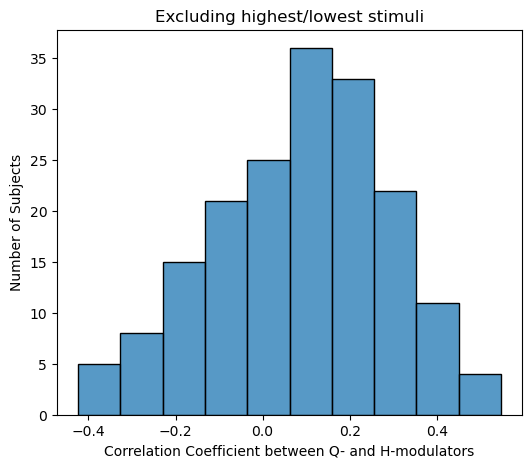

In [46]:
import seaborn as sns

# Create a histogram plot of corr
plt.figure(figsize=(6, 5))
sns.histplot(corr, kde=False, bins=10)
plt.title('Excluding highest/lowest stimuli')
plt.xlabel('Correlation Coefficient between Q- and H-modulators')
plt.ylabel('Number of Subjects')
plt.show()